# Setup

Imports

In [73]:
import platform
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import skimage.transform
import tabulate

from perlin_numpy import generate_perlin_noise_2d

Configuraciones

In [74]:
print(f"\n{tabulate.tabulate(platform.uname()._asdict().items())}")

plt.style.use('ggplot')
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})


-------  ----------
system   Windows
node     GOEDEL
release  10
version  10.0.19044
machine  AMD64
-------  ----------


Constantes

In [77]:
TAMAÑO_IMAGEN = 16
ANGULOS_DE_RAYOS = np.arange(0, 210, 30)

Función de utilidad

In [88]:
def ver_imagen(arreglo_imagen: np.ndarray,
               titulo: str,
               etiqueta_x: str = "$x$",
               etiqueta_y: str = "$y$",
               extent: list = None):
    plt.imshow(arreglo_imagen, origin="lower", extent=extent, aspect='auto')
    plt.colorbar()
    plt.title(titulo)
    plt.xlabel(etiqueta_x)
    plt.ylabel(etiqueta_y)
    plt.grid()

# Simulando datos de una tomografía

Generaremos un arreglo de densidades a través de ruido de Perlin 2D. Este arreglo será considerado desconocido, y es lo que queremos encontrar.

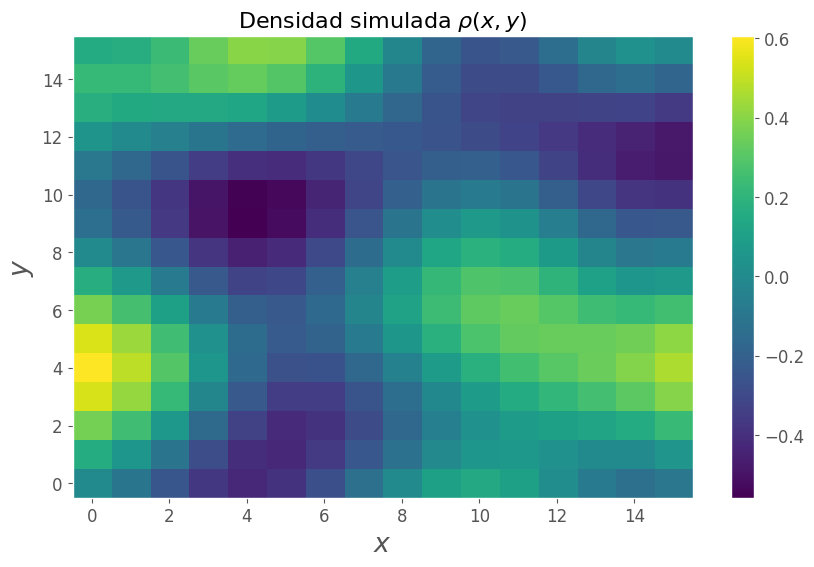

In [89]:
densidades_simuladas = generate_perlin_noise_2d((TAMAÑO_IMAGEN, TAMAÑO_IMAGEN), (2, 2))
ver_imagen(densidades_simuladas, r"Densidad simulada $\rho(x, y)$")

# Calculando la transformada

Esto se logra con `skimage.transform.radon`. Consideramos este arreglo como el cual realmente podemos medir:

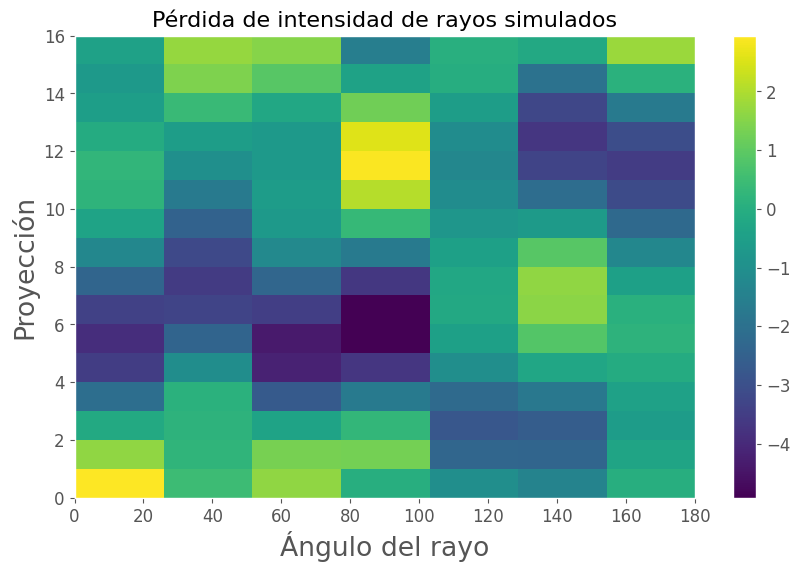

In [92]:
transformada_simulada = skimage.transform.radon(densidades_simuladas,
                                                theta=ANGULOS_DE_RAYOS)
ver_imagen(transformada_simulada, "Pérdida de intensidad de rayos simulados",
           "Ángulo del rayo", "Proyección", extent=[0, 180, 0, 16])
plt.xticks = ANGULOS_DE_RAYOS

# Modelo de optimización

Dado $\tilde{R}$ la transformada de Radon medida, podemos encontrar la densidad resolviendo el siguiente problema de optimización:

$$
\min_{\rho\in \mathbb{R}^{16\times 16}} \Vert R(\rho) - \tilde{R} \Vert 
$$

In [93]:
def costo(densidad_cantidata):
    como_imagen = densidad_cantidata.reshape(TAMAÑO_IMAGEN, TAMAÑO_IMAGEN)
    transformada_candidata = skimage.transform.radon(como_imagen, theta=ANGULOS_DE_RAYOS)
    error = transformada_candidata - transformada_simulada
    return (error*error).mean()

Suponemos que si bien no tenemos acceso a las densidades, sí lo tenemos a su promedio.

Así, construimos un punto inicial para la optimización como una imagen constante con valor igual a esta densidad promedio en todo punto.

In [94]:
densidades_iniciales = densidades_simuladas.mean()*np.ones_like(densidades_simuladas).flatten()
solucion = scipy.optimize.minimize(fun=costo, x0=densidades_iniciales)
solucion

      fun: 1.0764135707144125e-07
 hess_inv: array([[564.22220384, -28.3591873 , -23.902388  , ...,   8.29957649,
          5.94089039, -37.34267152],
       [-28.3591873 ,  12.57241347,  10.75778092, ...,  -1.78731999,
         -1.26634545,   0.86982644],
       [-23.902388  ,  10.75778092,  14.34937007, ...,  -4.5144232 ,
         -1.37276951,   1.94805518],
       ...,
       [  8.29957649,  -1.78731999,  -4.5144232 , ...,  16.3481744 ,
          3.5022007 ,  -5.30954232],
       [  5.94089039,  -1.26634545,  -1.37276951, ...,   3.5022007 ,
          5.05613714,   1.87516861],
       [-37.34267152,   0.86982644,   1.94805518, ...,  -5.30954232,
          1.87516861,   9.40938151]])
      jac: array([ 2.95894423e-06,  2.56483319e-06,  2.33937864e-06, -5.24033251e-07,
        2.70207866e-07,  1.74794362e-06,  2.05500930e-06,  3.44798360e-06,
        5.20077174e-06, -4.02558570e-07, -3.32238607e-06, -3.95327409e-06,
       -2.26524931e-06, -8.57989262e-08, -2.24613008e-07, -5.20538492e

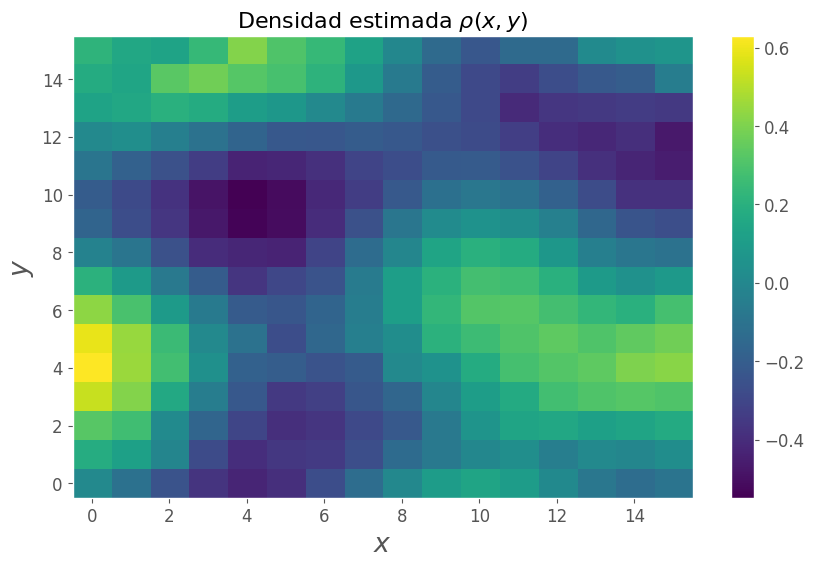

In [95]:
densidades_estimadas = solucion.x.reshape(TAMAÑO_IMAGEN, TAMAÑO_IMAGEN)
ver_imagen(densidades_estimadas, r"Densidad estimada $\rho(x, y)$")

La solución es casi idéntica a lo que buscamos reconstruir, con un error de `1.1972447739390376e-07`.

Así, se puede reconstruir la imagen (resolver el problema inverso) con un método simple de optimización, asumiendo que tenemos acceso a una función que resuelve el problema directo (calcular la transformada de Radon). En la práctica esto no es problema, pues calcular la transformada de Radon solamente requiere integrales a lo largo de un rayo.

Sí puede ser más desafiente escalar esta metodología para imágenes más grandes, pues una de `16\times16` ya requirió 25 segundos para resolver.
